Can you believe that you can write a python script to generate handwritten digits without using DL frameworks like **TensorFlow** or **pytorch**?  In this demo, I'm going to walk you through an example of building a **Generative Adverserial Network** ([GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network)) to generate **MNIST** handwritten digits using `autodiff` (which only depends on `numpy`).


#### A little background on GANs:

<p align="center"><img src="GANs.png" width="600"> </p>

image credit: [https://skymind.ai/wiki/generative-adversarial-network-gan](https://www.google.com/url?sa=i&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwjczYv39prjAhWRM94KHbMuBHYQjhx6BAgBEAM&url=https%3A%2F%2Fskymind.ai%2Fwiki%2Fgenerative-adversarial-network-gan&psig=AOvVaw3lqvE8XzKsLOi-PxnaxWqv&ust=1562318182236540)

Conceptually, the game of GAN involves two players: the **police** (i.e. Discriminator) tries to detect fake banknotes from real ones, while the **counterfeiter** (i.e. Generator) tries to produce fake money that they hope can fool the police (make the police believe the fake money is indeed real money).

Technically, training a GAN involves the following steps:

1. First we sample a batch of vectors $z$ from a $d$-dimensional distribution $p_{z}(z)$. For example, each $z$ could be a 100-dimensional vector, where its components are identically (e.g. Standard Normal or random uniform distribution) and independently distributed (I.I.D.)

$$z \sim p_{z}(z), z \in \mathbb{R}^{100}$$

2. Then we feed the batch of $z$'s into the **Generator** $G(z; \theta_{g})$, which is a neural network (e.g. with convolutional layers, fully connected layers etc.) that turns each $z$ into a 784-dimensional vector that can be reshaped into a 28 by 28 gray scale image.

$$x_{fake} = G(z), x_{fake} \in \mathbb{R}^{784}$$

Note: the generated images $x_{fake}$ follows a distribution that we refer to as $p_{g}(x)$.

3. Next, we are going to sample a batch of real images $x_{real}$, from our training set -- a 784-dimensional distribution $p_{data}(x)$

Note: both $x_{real}$ and $x_{fake}$ are 784-dimensional vectors, except that they come from different distributions, i.e. $p_{data}(x)$ and $p_{g}(x)$
4. Finally, we will feed $x_{real}$'s and $x_{fake}$'s into the **Discriminator** $D(x; \theta_{d})$, which is also a neural network that performs binary classification on each $x_{real}$ and $x_{fake}$. We **train the Discriminator** by updating its parameters $\theta_{d}$, in the hope that $x_{real}$ outputs 1's, and $x_{fake}$ outputs 0's. In the *meantime*, we **train the Generator** by updating its parameters $\theta_{g}$, in the hope that $x_{fake}$ outputs 1's.

Through this kind of *adverserial* training, we make the Generator and Discriminator "screw up" each other's job. In the end, we would like to make the distribution $p_{g}(x)$ to be as close to $p_{data}(x)$ as possible.


#### Wasserstein GANs

The GAN built and trained in the fashion as described above is referred to as **DCGAN** (Deep Convolutional GAN), which has a number of drawbacks that make it very unstable to train. Here we're going to implement a different version of GAN, **Wasserstein GAN**, which comes with a redesigned but very simple loss function that make it much easier to train. It differs from a **DCGAN** in step 4:

Rather than train the **Discriminator** as a binary classifier, it maximizes the difference between the **Discriminator** outputs for the input $x_{fake}$ and $x_{real}$, or equivalently minimizes $D(x_{fake}; \theta_{d}) - D(x_{real}; \theta_{d})$ (i.e. make $D(x_{fake}; \theta_{d})$ smaller, and make $D(x_{real}; \theta_{d})$ larger). Adversially, the **Generator** maximizes the **Discriminator** outputs for the input $x_{fake}$, or equivalently minimizes $-D(x_{fake}; \theta_{d})$.

In [1]:
import gzip
import numpy as np

import autodiff as ad
from autodiff import initializers
from autodiff import optimizers

To train the GAN, we will only use the MNIST handwritten digits (no labels are needed). We are going to need a function to read and parse the MNIST data, and we are going to normalize the pixel values into the range `[-1, 1]`.

In [2]:
def read_mnist_images(fn):
  with gzip.open(fn, 'rb') as f:
    content = f.read()
    num_images = int.from_bytes(content[4:8], byteorder='big')
    height = int.from_bytes(content[8:12], byteorder='big')
    width = int.from_bytes(content[12:16], byteorder='big')
    images = np.fromstring(content[16:], dtype=np.uint8).reshape((num_images, height, width))

  return images

train_images = read_mnist_images('train-images-idx3-ubyte.gz')

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# training set contains 60000 images
print(train_images.shape)

(60000, 28, 28, 1)


The GAN is composed of a Generator network and a Discriminator network, each of which contains trainable weights. The trainable weights may need different initializers:

* Random uniform initializer for convolutional and fully connected layers.
* Zeros initializer for biases, and offsets of Batch Normalization. 
* Ones initializer for scales of Batch Normalization.

We set 128 as the dimensionality of the noise vector $z$, and 64 as the batch size.

In [3]:
rui = initializers.RandomUniformInitializer(minval=-0.0001, maxval=0.0001)
zi = initializers.ZerosInitializer()
oi = initializers.OnesInitializer()

noise_dim = 128
BATCH_SIZE = 64

The Generator converts a `[BatchSize, 128]` tensor into a `[BatchSize, 28, 28, 1]` tensor (i.e. the fake images).

The first layer -- **fully connected** -- increases the depth dimension from 100 to 12544 (7 * 7 * 256), then the tensor is reshaped into `(None 7, 7, 256)`

The layers are listed below:

|layer|stride|kernel| output dimension|output tensor shape|
|--|--|--|--|--|
|Fully connected|n/a|n/a|12544|[BatchSize, 12544]|
|Reshape|n/a|n/a|n/a|[BatchSize, 7, 7, 256]
|Transposed Conv2D|1|5|128|[BatchSize, 7, 7, 128]|
|BatchNorm|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|LeakReLU|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|Transposed Conv2D|2|5|64|[BatchSize, 14, 14, 64]|
|BatchNorm|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|LeakReLU|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|Transposed Conv2D|2|5|1|[BatchSize, 28, 28, 1]|
|Tanh|n/a|n/a|n/a|[BatchSize, 28, 28, 1]|

In [4]:
def build_generator_variables():
  # 12544 = 7 * 7 * 256
  dense0_weight = ad.variable((noise_dim, 12544), rui)
  dense0_offset = ad.variable((12544,), zi)
  dense0_scale = ad.variable((12544,), oi)
  dense0_moving_mean = ad.variable((12544,), zi, trainable=False)
  dense0_moving_variance = ad.variable((12544,), oi, trainable=False)

  tconv0_weight = ad.variable((5, 5, 128, 256), rui)
  tconv0_offset = ad.variable((128,), zi)
  tconv0_scale = ad.variable((128,), oi)
  tconv0_moving_mean = ad.variable((128,), zi, trainable=False)
  tconv0_moving_variance = ad.variable((128,), oi, trainable=False)

  tconv1_weight = ad.variable((5, 5, 64, 128), rui)
  tconv1_offset = ad.variable((64,), zi)
  tconv1_scale = ad.variable((64,), oi)
  tconv1_moving_mean = ad.variable((64,), zi, trainable=False)
  tconv1_moving_variance = ad.variable((64,), oi, trainable=False)

  tconv2_weight = ad.variable((5, 5, 1, 64), rui)
  
  var_list = [dense0_weight, dense0_offset, dense0_scale, dense0_moving_mean, dense0_moving_variance,
             tconv0_weight, tconv0_offset, tconv0_scale, tconv0_moving_mean, tconv0_moving_variance,
             tconv1_weight, tconv1_offset, tconv1_scale, tconv1_moving_mean, tconv1_moving_variance,
             tconv2_weight]
  return var_list
  
def generator(noise, var_list, is_training=True, epsilon=0.001, decay=0.999):
  [dense0_weight, dense0_offset, dense0_scale, dense0_moving_mean, dense0_moving_variance,
   tconv0_weight, tconv0_offset, tconv0_scale, tconv0_moving_mean, tconv0_moving_variance,
   tconv1_weight, tconv1_offset, tconv1_scale, tconv1_moving_mean, tconv1_moving_variance,
   tconv2_weight] = var_list
  
  dense0 = ad.relu(
      ad.fused_batch_norm(ad.matmul(noise, dense0_weight),
          dense0_scale,
          dense0_offset,
          dense0_moving_mean,
          dense0_moving_variance,
          is_training=is_training, epsilon=epsilon, decay=decay))
  
  reshaped = ad.reshape(dense0, [-1, 7, 7, 256])
  
  tconv0 = ad.relu(
      ad.fused_batch_norm(ad.conv2d_transpose(reshaped, tconv0_weight, [1, 1], 'SAME'),
          tconv0_scale,
          tconv0_offset,
          tconv0_moving_mean,
          tconv0_moving_variance,
          is_training=is_training, epsilon=epsilon, decay=decay))

  tconv1 = ad.relu(
      ad.fused_batch_norm(ad.conv2d_transpose(tconv0, tconv1_weight, [2, 2], 'SAME'),
          tconv1_scale,
          tconv1_offset,
          tconv1_moving_mean,
          tconv1_moving_variance,
          is_training=is_training, epsilon=epsilon, decay=decay))

  tconv2 = ad.tanh(ad.conv2d_transpose(tconv1, tconv2_weight, [2, 2], 'SAME'))

  return tconv2


The Discriminator converts a `[BatchSize, 28, 28, 1]` tensor into a `[BatchSize, 1]` tensor, which can be interpreted as "scores" for the input images -- the larger the score, the more the Discriminator believes that the input image is real, no matter it is indeed real or fake.

The architecture of Discriminator is just like a regular convolutional image classification network. The layers are listed below:

|layer|stride|kernel| output dimension|output tensor shape|
|--|--|--|--|--|
|Conv2D|2|5|64|[BatchSize, 14, 14, 64]|
|LeakyReLU|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|Dropout|n/a|n/a|n/a|[BatchSize, 14, 14, 64]|
|Conv2D|2|5|128|[BatchSize, 7, 7, 128]|
|LeakyReLU|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|Dropout|n/a|n/a|n/a|[BatchSize, 7, 7, 128]|
|Reshape|n/a|n/a|n/a|[BatchSize, 6272]|
|Fully connected|n/a|n/a|1|[BatchSize, 1]|

In [5]:
def build_discriminator_variables():
  conv0_weight = ad.variable((5, 5, 1, 64), rui)
  conv0_biases = ad.variable((64,), zi)

  conv1_weight = ad.variable((5, 5, 64, 128), rui)
  conv1_biases = ad.variable((128,), zi)

  dense0_weight = ad.variable((6272, 1), rui)
  dense0_biases = ad.variable((1,), zi)

  var_list = [conv0_weight, conv0_biases, conv1_weight, conv1_biases, dense0_weight, dense0_biases]
  return var_list
  
def discriminator(images, var_list, is_training=True):
  [conv0_weight, conv0_biases, conv1_weight, conv1_biases, dense0_weight, dense0_biases] = var_list
  
  conv0 = ad.leaky_relu(ad.conv2d(images, conv0_weight, [2, 2], 'SAME') + conv0_biases, alpha=0.2)

  conv1 = ad.leaky_relu(ad.conv2d(conv0, conv1_weight, [2, 2], 'SAME') + conv1_biases, alpha=0.2)

  reshaped = ad.reshape(conv1, (-1, 7 * 7 * 128))

  logits = ad.add(ad.matmul(reshaped, dense0_weight), dense0_biases)

  return logits

Finally, we create the computeational `graph`, and place nodes inside the graph.

In [6]:
graph = ad.Graph()
with graph.as_default_graph():
  noise = ad.placeholder((BATCH_SIZE, noise_dim))
  # create variables for generator and discriminator separately
  g_var_list = build_generator_variables()
  d_var_list = build_discriminator_variables()
  # generator in Training mode
  fake_images = generator(noise, g_var_list, True)
  real_images = ad.placeholder((BATCH_SIZE, 28, 28, 1))
  # discriminator in Training mode
  real_logits = discriminator(real_images, d_var_list, True)
  fake_logits = discriminator(fake_images, d_var_list, True)
  
  discriminator_loss = ad.reduce_mean(fake_logits) - ad.reduce_mean(real_logits)
  
  generator_loss = -ad.reduce_mean(fake_logits)

We initialize the variables, and create a `RunTime` for the `graph`:

In [7]:
graph.initialize_variables()
runtime = ad.RunTime()
graph.set_runtime(runtime)

We use RMSProp optimizer to train both Discriminator and Generator.

In [8]:
optimizer = optimizers.RMSPropOptimizer(alpha=0.00005, rho=0.9, momentum=0.0, epsilon=1e-7)

We train the GAN for 10000 iteraions. In each iteration, we sample `BATCH_SIZE` real images from the training set, and also `BATCH_SIZE` 128-dimensional vectors from the Standard Normal distribution.

The gradients w.r.t Discriminator variables and Generator variables are computed separately.

**Note**: in **Wasserstein GAN**, the Discriminator is trained for 5 iterations for every iteration the Generator is trained. In addition, we must bound Discriminator's variables in some range (e.g. `[-0.01, 0.01]` as suggested in the paper).

Finally, for every 100 iterations, we print out the loss for Discriminator and Generator, and save the variables to `dcgan_*.npy`.

In [9]:
for i in range(10000):
  # train discriminator for 5 iterations
  for j in range(5):
    which = np.random.choice(train_images.shape[0], BATCH_SIZE, False)
    inputs_val = train_images[which]
    feed_dict = {noise: np.random.normal(size=(BATCH_SIZE, noise_dim)).astype('float32'),
                 real_images: inputs_val}
    
    with runtime.forward_backward_cycle(grad_stopped_nodes=[fake_images]):
      d_grads_and_vars = optimizer.compute_gradients(discriminator_loss, feed_dict, d_var_list)
      d_loss_val = discriminator_loss.forward(feed_dict)

    optimizer.apply_gradients(d_grads_and_vars)
    # clip the discriminator variables 
    for v in d_var_list:
      v.set_val(np.clip(v.val, -0.01, 0.01))

  # train generator for 1 iteration    
  feed_dict = {noise: np.random.normal(size=(BATCH_SIZE, noise_dim)).astype('float32'),
              real_images: inputs_val}
  with runtime.forward_backward_cycle():
    g_grads_and_vars = optimizer.compute_gradients(generator_loss, feed_dict, g_var_list)
    g_loss_val = generator_loss.forward(feed_dict)

  optimizer.apply_gradients(g_grads_and_vars)

  if i % 100 == 0:
    print(i, d_loss_val, g_loss_val)  
    graph.save_variables('wgan_%d' % i)  
graph.save_variables('wgan_10000')    

0 -0.0028457008213028474 -2.206894525391377e-05
100 -2.2140375340110623 -27.601818959430076
200 -2.373267053819953 -12.154273445272935
300 -3.204279638771963 -3.6142749628198443
400 -4.559071136983151 -5.148985372536839
500 -4.628447878639041 -7.556854159000496
600 -4.325047108443486 -7.095674413840048
700 -3.147870992666361 -5.360230123297857
800 -3.455938051451069 -5.896094826548431
900 -2.7021367016028517 -7.009929843531759
1000 -2.459975790677685 -8.442987482864263
1100 -1.5340544898832693 -7.576318547086014
1200 -1.2146100043525223 -7.103914514981678
1300 -0.7795781168543199 -3.838457905314381
1400 -0.40145936125039583 -5.95137422442725
1500 -0.40855780345411663 -2.769795755649117
1600 -0.15482000578974553 -3.3826280842303684
1700 -0.13156187095463423 -4.4280854652853225
1800 -0.041698992842222005 -5.056929113399333
1900 -0.029336150470168132 -2.9943308653316034
2000 -0.053008902027015026 -3.607313646499521
2100 -0.016895919258456793 -2.8302656674948588
2200 -0.02097961935931858 -

Once we are done with training, we can test out generating a few images.

In [10]:
import imageio
import glob
import os
import matplotlib.pyplot as plt
from IPython import display

We create a separate graph for generator, and set the `is_training` flag to `False`.

In [11]:
test_graph = ad.Graph()
with test_graph.as_default_graph():
  noise = ad.placeholder((None, noise_dim))
  g_var_list = build_generator_variables()
  fake_images = generator(noise, g_var_list, is_training=False)

runtime = ad.RunTime()
test_graph.set_runtime(runtime)  

We create a helper function to plot a 10x10 grid of generated images.

In [12]:
def plot_images(images_val, epoch):
  fig = plt.figure(figsize=(10, 10))
  for i in range(images_val.shape[0]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(images_val[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  if not os.path.exists('images'):
    os.mkdir('images')

  plt.savefig('images/{:05d}.png'.format(epoch))
  plt.show()

Then we are going to read the variables in different training iterations, and generate the images.

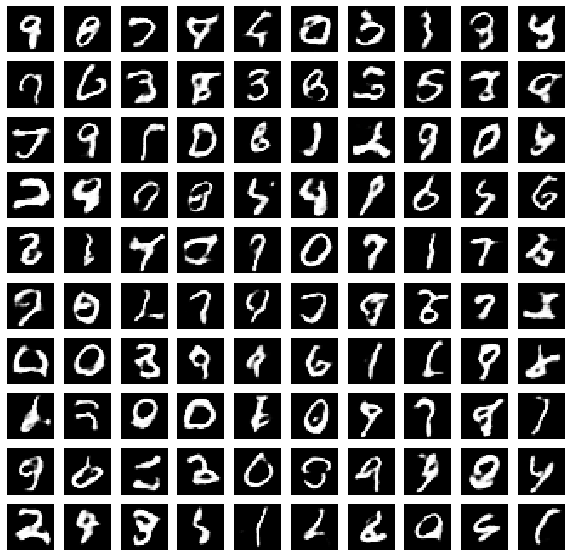

In [13]:
var_list = test_graph.get_variables(False) # get both trainable and non-trainable variables (for batch norm)
random_state = np.random.RandomState(0)

# We use a fixed noise vector, so we can see how the generated images evolve as training progresses 
# given the SAME input noise vector. 
feed_dict = {noise: random_state.normal(size=(100, noise_dim)).astype('float32')}

# read the variables in different iterations 
for i in range(0, 10001, 100):
  d = np.load('wgan_%d.npy' % i, allow_pickle=True).item()
  for v in var_list:
    v.set_val(d[v.name])
  
  # generate the images
  with runtime.forward_backward_cycle():
    images_val = fake_images.forward(feed_dict) 
  print(i)
  display.clear_output(wait=True)
  # plot the images
  plot_images(images_val, i)

Finally, we create a gif file so we can easily see how the generated images evolve given the **same** input noise vector.

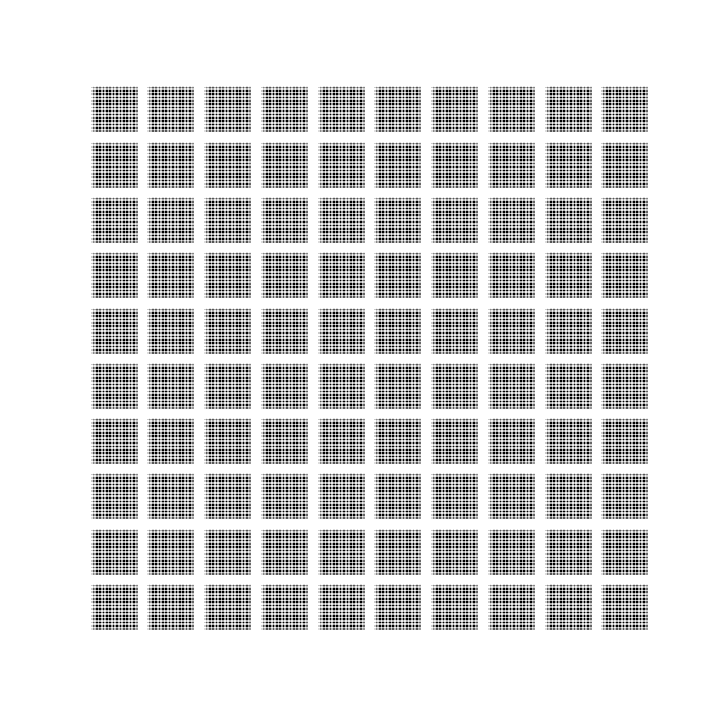

In [14]:
with imageio.get_writer('wgan.gif', mode='I') as writer:
  filenames = glob.glob('images/*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
os.system('cp wgan.gif wgan.gif.png')
display.Image(filename="wgan.gif.png")